In [120]:
import cv2
import imutils
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf 
import argparse
import pandas as pd
from scipy import stats
model = tf.keras.models.load_model('/Model_saves/first.keras')

c:\Users\Er-Pr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:408: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [121]:
from transformers import AutoImageProcessor, ViTForImageClassification, AutoModelForImageClassification
from transformers import pipeline
pipe = pipeline("image-classification", model="farleyknight-org-username/vit-base-mnist")
p1 = AutoImageProcessor.from_pretrained("farleyknight-org-username/vit-base-mnist")
m1 = ViTForImageClassification.from_pretrained("farleyknight-org-username/vit-base-mnist")
pipe = pipeline("image-classification", model="AliGhiasvand86/digit_recognition2")
p2 = AutoImageProcessor.from_pretrained("AliGhiasvand86/digit_recognition2")
m2 = AutoModelForImageClassification.from_pretrained("AliGhiasvand86/digit_recognition2")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
c:\Users\Er-Pr\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [122]:
def largest_feature(i, tl, br):
	img = i.copy()
	h, w = img.shape[:2]
	max_area = 0
	coordinates = (None, None)
	if tl is None:
		tl = [0, 0]
	if br is None:
		br = [w, h]	
	for x in range(tl[0], br[0]):
		for y in range(tl[1], br[1]):
			if img.item(y,x) == 255 and x < w and y < h:
				area = cv2.floodFill(img, None, (x,y), 64)
				if area[0] > max_area:
					max_area = area[0]
					coordinates = (x, y)
	for x in range(w):
		for y in range(h):
			if img.item(y,x) == 255 and x < w and y < h:
				cv2.floodFill(img, None, (x,y), 64)		
	cover = np.zeros(((h + 2), (w + 2)), np.uint8)
	if all([p is not None for p in coordinates]):
		cv2.floodFill(img, cover, coordinates, 255)
	top, bottom, left, right = h, 0, w, 0
	
	for x in range(w):
		for y in range(h):
			if img.item(y, x) == 64:
				cv2.floodFill(img, cover, (x, y), 0)
			
			if img.item(y, x) == 255:
				top = min(y, top)
				bottom = max(y, bottom)
				left = min(x, left)
				right = max(x, right)
			
	box = [[left, top], [right, bottom]]
	return img, np.array(box, dtype='float32'), coordinates

def align(img, size, margin=0, background=0):
	h, w = img.shape[:2]
	def centre(length):
		if length % 2 == 0:
			side1 = int((size - length) / 2)
			side2 = side1
		else:
			side1 = int((size - length) / 2)
			side2 = side1 + 1
		return side1, side2
	if h > w:
		t_pad = int(margin / 2)
		b_pad = t_pad
		ratio = (size - margin) / h
		w, h = int(ratio *  w), int(ratio * h)
		l_pad, r_pad = centre(w)
	else:
		l_pad = int(margin / 2)
		r_pad = l_pad
		ratio = (size - margin) / w
		w, h = int(ratio * w), int(ratio * h)
		t_pad, b_pad = centre(h)
	img = cv2.resize(img, (w,h))
	img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
	return cv2.resize(img, (size, size))

def digit_recognize(image, model):
	h, w = image.shape[:2]
	r = 28/w
	dim = (28, int(r*h))
	image = cv2.resize(image, dim)
	for i in range(28):
		for j in range(28):
			if image[i][j] < 150:	
				image[i][j] = 255
			else:
				image[i][j] = 0
	
	image = image.reshape((1, 784)).astype('float32')
	image = image / 255
	prediction = model.predict(image)
	return prediction.argmax(), prediction

In [123]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
image = cv.imread("Test/W (1).jpg")
h, w, d = image.shape
r = 300/w
dim = (300, int(r*h))
image = cv2.resize(image, dim)
grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

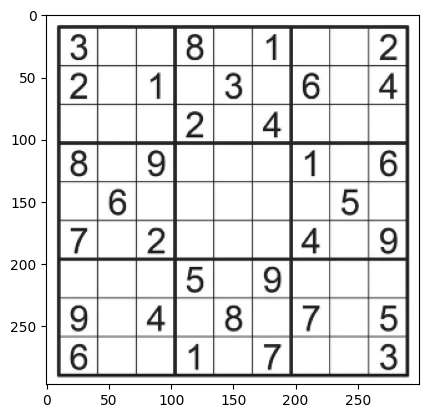

In [124]:
plt.imshow(image)

In [125]:
blur = cv2.GaussianBlur(grey,(9,9),0)
thres = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)

In [126]:
cnts,hie = cv2.findContours(thres.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
cnts

(array([[[10,  8]],
 
        [[ 9,  9]],
 
        [[ 8, 10]],
 
        ...,
 
        [[13,  8]],
 
        [[12,  8]],
 
        [[11,  8]]], dtype=int32),)

In [127]:
biggest = None
max_area = 0
for i in cnts:
    area = cv2.contourArea(i)
    peri = cv2.arcLength(i,True)
    app = cv2.approxPolyDP(i,0.02*peri,True)
    if area>max_area and len(app)==4:
        max_area = area
        biggest = app

In [128]:
biggest

array([[[ 10,   8]],

       [[  8, 290]],

       [[290, 291]],

       [[291,   9]]], dtype=int32)

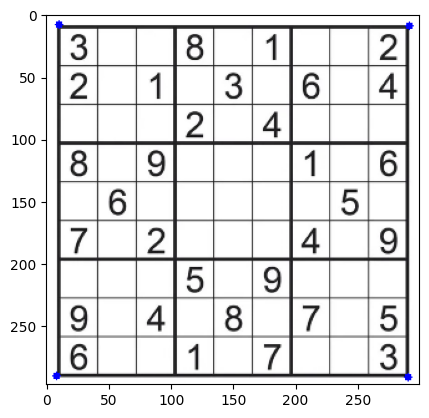

In [129]:
check = image.copy()
plt.imshow(cv2.drawContours(check,biggest,-1,(0,0,255),5))

In [130]:
big = biggest.reshape((4,2))
coord = np.zeros((4,2),np.float32)
sum = np.sum(big,axis=1)
diff = np.diff(big,axis=1)
coord[0] = big[sum.argmin()]
coord[2] = big[sum.argmax()]
coord[1] = big[diff.argmin()]
coord[3] = big[diff.argmax()]

In [131]:
pts = np.float32([[0,0], [450,0], [450,450], [0,450]])
pers = cv2.getPerspectiveTransform(coord, pts)

In [132]:
pers = cv2.warpPerspective(grey, pers, (450,450))

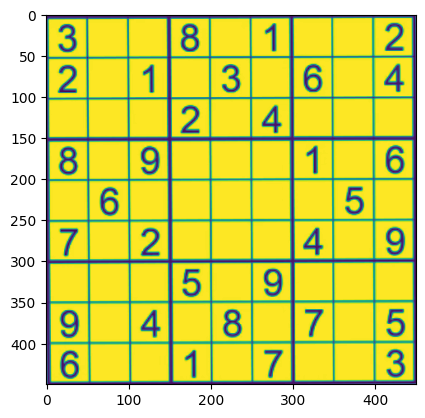

In [133]:
plt.imshow(pers)

In [134]:
sq = []
sd = 450/9

for i in range(9):
    for j in range(9):
        tl = (i*sd,j*sd)
        br = ((i+1)*sd,(j+1)*sd)
        sq.append((tl,br))


In [135]:
digits = []
ind = 0
pers = cv2.adaptiveThreshold(pers,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)

for i in sq:
    cell = pers[int(i[0][0]):int(i[1][0]),int(i[0][1]):int(i[1][1])]
    h, w = cell.shape[:2]
    margin = int(np.mean([h,w])/2.5)
    _, box, seed = largest_feature(cell, [margin, margin], [w - margin, h - margin])
    cell = cell[int(box[0][1]):int(box[1][1]), int(box[0][0]):int(box[1][0])]
    w = box[1][0] - box[0][0]
    h = box[1][1] - box[0][1]
    if w > 0 and h > 0 and (w*h) > 100 and len(i) > 0:
        digits.append(align(cell,28,4))
    else:
        digits.append(np.zeros((28,28), np.uint8))

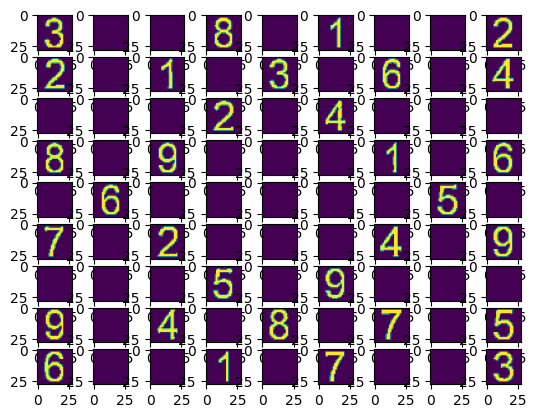

In [136]:
fx,ax = plt.subplots(9,9)
ind = 0
for i in range(9):
    for j in range(9):
        ax[i,j].imshow(digits[ind])
        ind = ind+1

In [137]:
preds = []
ind = 0
for i in range(9):
    te = []
    for j in range(9):
        res = cv2.countNonZero(digits[ind])
        if res>=150:
            take,numm = digit_recognize(digits[ind],model)
            te.append(take)
        elif res<150 and res>=100:
            te.append(1)
        else:
            te.append(' ')
        ind = ind+1
    preds.append(te)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [138]:
df = pd.DataFrame(preds)

In [139]:
temp = df.to_numpy()
df

,0,1,2,3,4,5,6,7,8
0,3,,,8,,,,,2
1,2,,1,,3,,8,,4
2,,,,7,,4,,,
3,8,,9,,,,,,8
4,,8,,,,,,5,
5,1,,7,,,,4,,9
6,,,,5,,9,,,
7,9,,4,,8,,7,,5
8,6,,,,,1,,,3


In [140]:
def fin_pred(img):
    finals = []
    finals.append(digit_recognize(img,model)[0])
    inputs = p1(cv.cvtColor(img,cv.COLOR_GRAY2BGR), return_tensors="pt")
    outputs = m1(**inputs).logits
    finals.append(outputs.argmax(-1).item())
    inputs = p2(cv.cvtColor(img,cv.COLOR_GRAY2BGR), return_tensors="pt")
    outputs = m2(**inputs).logits
    finals.append(outputs.argmax(-1).item())
    if stats.mode(np.array(finals))[1]==1:
        return finals[0], finals
    return stats.mode(np.array(finals))[0], finals

In [141]:
preds = []
ind = 0
for i in range(9):
    te = []
    for j in range(9):
        tel = fin_pred(digits[ind])[0]
        if tel==0:
            te.append(' ')
        else:
            te.append(tel)
        ind+=1

    preds.append(te)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

In [142]:
pd.DataFrame(preds)

,0,1,2,3,4,5,6,7,8
0,3,,,8,,1,,,2
1,2,,1,,3,,8,,4
2,,,,7,,4,,,
3,8,,9,,,,1,,8
4,,8,,,,,,5,
5,7,,7,,,,4,,9
6,,,,5,,9,,,
7,9,,4,,8,,7,,5
8,6,,,1,,7,,,3


In [147]:
fin_pred(digits[47])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


(7, [7, 2, 1])